In [43]:
%load_ext autoreload
%autoreload 2
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.cluster import DBSCAN
#from model import SimCLRModel
#from mlp import MLP
import torch.nn.functional as F

device = torch.device('cuda') if torch.cuda.is_available() else (torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu'))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
class GwakDataset(Dataset):
    def __init__(self, 
                 path='/n/holystore01/LABS/iaifi_lab/Lab/phlab-neurips25/GWAK/', 
                 normalize=False):
        background = self.fill_data(path+'/background.npz', normalize=normalize, label=0)
        bbh = self.fill_data(path+'bbh_for_challenge.npy', normalize=normalize, label=1)
        sglf = self.fill_data(path+'sglf_for_challenge.npy', normalize=normalize, label=2)
        self.data = np.concatenate([background[0], bbh[0], sglf[0]], axis=0)
        self.labels = np.concatenate([background[1], bbh[1], sglf[1]], axis=0)

    def fill_data(self, path, normalize=True, label=0):
        if path.endswith('npz'):
            data = np.load(path)['data']
        else:
            data = np.load(path)
        if normalize:
            stds = np.std(data, axis=-1)[:, :, np.newaxis]
            data = data/stds
        #data = np.swapaxes(data, 1, 2)
        data = np.float32(data)
        target = np.full(data.shape[0], label)
        return data, target
    
    def generate_augmentation(self,batch):
        return None
    
    def normalize(self,batch):
        return (batch - self.mean.to(batch)) / self.std.to(batch)

    def __len__(self):
        return self.labels.shape[0]

    def __getitem__(self,idx):
        return self.data[idx, :, :], self.labels[idx]

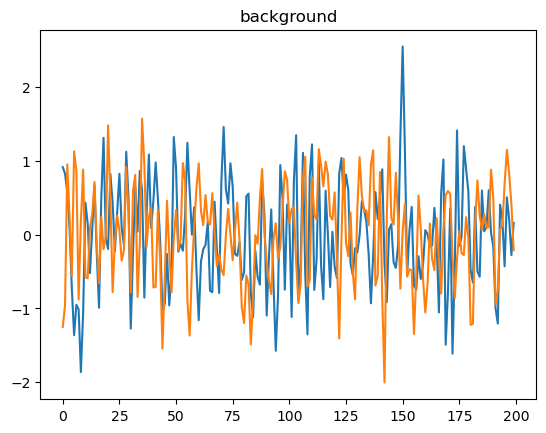

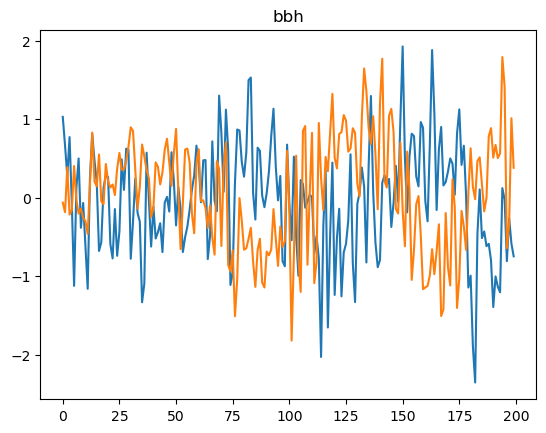

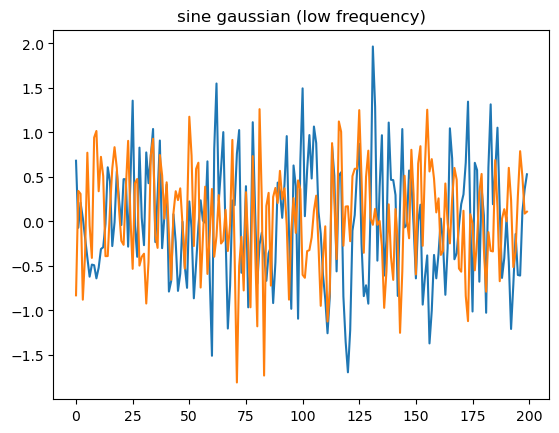

In [45]:
dset = GwakDataset()
generator = torch.Generator().manual_seed(42)
trainset, testset = torch.utils.data.random_split(dset, [0.8,0.2], generator=generator)

data = dset.data
labels = dset.labels

# plot time series for each dataset
for i in range(3):
    if i ==0:
        text='background'
    elif i ==1:
        text='bbh'
    elif i==2:
        text='sine gaussian (low frequency)'
    selc = data[labels==i][0]
    times = np.arange(selc.shape[1])
    fig = plt.figure()

    plt.plot(times, selc[0,:])
    plt.plot(times, selc[1,:])
    plt.title(text)
    fig.show()

In [ ]:
import sys
sys.path.append('../../')

from models.losses import SupervisedSimCLRLoss
from models.networks import MLP
from models.litmodels import SimCLRModel
from models.resnet_1d import ResNet1D
from tqdm import tqdm

temp = 0.05
criterion = SupervisedSimCLRLoss(temperature=temp)

# Define a dummy CNN model
embed_dim = 8
embedder = ResNet1D(in_channels=2, layers=[3, 4, 6, 3], classes=embed_dim).to(device)
projector = MLP(input_dim=embed_dim,hidden_dims=[embed_dim],output_dim=embed_dim).to(device)
model = SimCLRModel(embedder, projector).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.5e-3)

# Training loop
num_epochs = 100
batch_size = 350
# Dataloaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

losses = []
for epoch in tqdm(range(num_epochs)):
    model.train()
    epoch_loss = []
    for batch_data, labels in dataloader:
        batch_data = batch_data.float().to(device)

        # Potential to add any augmentation here
        features = model(batch_data).unsqueeze(1)
        
        # Compute SimCLR loss
        loss = criterion(features,labels=labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss.append(loss.item())
    mean_loss = np.mean(epoch_loss)
    losses.append(mean_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {mean_loss:.4f}')
    

plt.figure(figsize=(8,6))
plt.plot(np.arange(len(losses)),losses)

  1%|          | 1/100 [00:26<44:24, 26.91s/it]

Epoch [1/100], Loss: 4.2741


  2%|▏         | 2/100 [00:53<43:56, 26.90s/it]

Epoch [2/100], Loss: 4.0544


  3%|▎         | 3/100 [01:20<43:32, 26.93s/it]

Epoch [3/100], Loss: 4.0367


  4%|▍         | 4/100 [01:47<43:02, 26.90s/it]

Epoch [4/100], Loss: 4.0279


  5%|▌         | 5/100 [02:14<42:36, 26.91s/it]

Epoch [5/100], Loss: 4.0243


  6%|▌         | 6/100 [02:41<42:08, 26.90s/it]

Epoch [6/100], Loss: 4.0239


  7%|▋         | 7/100 [03:08<41:39, 26.88s/it]

Epoch [7/100], Loss: 4.0204


  8%|▊         | 8/100 [03:35<41:16, 26.92s/it]

Epoch [8/100], Loss: 4.0223


  9%|▉         | 9/100 [04:02<40:47, 26.89s/it]

Epoch [9/100], Loss: 4.0178


 10%|█         | 10/100 [04:28<40:18, 26.87s/it]

Epoch [10/100], Loss: 4.0181


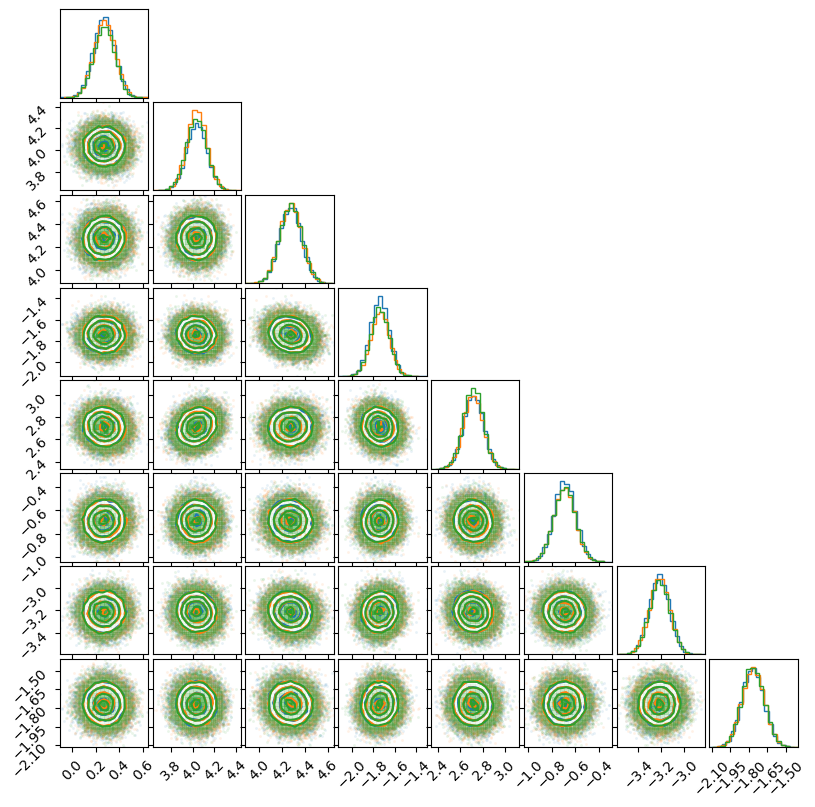

In [47]:
#data = testset[:][0].float()
#labels = testset[:][1].numpy()
data = torch.from_numpy(testset[:][0])
labels = testset[:][1]
with torch.no_grad():
    output = []
    for sp in torch.split(data,10000):
        #sp = testset.normalize(sp)
        output.append(model(sp.to(device),embed=True).cpu().numpy())
    output = np.concatenate(output,axis=0)

import corner
fig = plt.figure(figsize=(8,8))
corner.corner(output[labels==0],fig=fig,color="C0")
corner.corner(output[labels==1],fig=fig,color="C1")
corner.corner(output[labels==2],fig=fig,color="C2")
plt.show()